In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
import pandas as pd
from statsmodels.graphics.api import qqplot

from statsmodels.tsa.seasonal import seasonal_decompose


### Hourly Load Data analysis
Do LSTM analysis of Load Daa

Main reference: https://github.com/nachi-hebbar/Time-Series-Forecasting-LSTM/blob/main/RNN_Youtube.ipynb

Code to make datetime and remove NaNs:

In [3]:
# load_spp_eia_Jun19_Oct22=pd.read_csv(r"..\ImportData\load_spp_eia_Jun19_Oct22.csv")
# load_spp_eia_Jun19_Oct22['datetime'] = pd.to_datetime(load_spp_eia_Jun19_Oct22["GMTTime"])
# load_spp_eia_Jun19_Oct22_nan_removed = load_spp_eia_Jun19_Oct22[np.logical_not(load_spp_eia_Jun19_Oct22['1 Min ACE Average'].isnull())]
# load_spp_eia_Jun19_Oct22_nan_removed = pd.read_pickle("load_spp_eia_Jun19_Oct22_nan_removed.pkl")


In [4]:
load_spp_eia_Jun19_Oct22_nan_removed = pd.read_pickle("load_spp_eia_Jun19_Oct22_nan_removed.pkl")
# load_spp_eia_Jun19_Oct22_nan_removed = pd.read_csv(r"/content/drive/MyDrive/NYU courses/Sem 3/pTSA/Project/Data/load_spp_eia_Jun19_Oct22.csv")
load_spp_eia_Jun19_Oct22_nan_removed.index.freq='min'

In [5]:
day_len = 24
month_len = 720
yr_len = 8760
# new_data_len = 26304
new_data_len = len(load_spp_eia_Jun19_Oct22_nan_removed)

In [6]:
len(load_spp_eia_Jun19_Oct22_nan_removed)

29112

In [7]:
load_spp_eia_Jun19_Oct22_nan_removed.iloc[:new_data_len]

,Unnamed: 0,UTC time,Local date,Hour,Local time,Time zone,D,CSWS,SPRM,EDE,...,KCPL,LES,NPPD,OKGE,OPPD,SPS,SECI,WR,WAUE,WFEC
0,34824,2019-06-21 06:00:00,2019-06-21,1,2019-06-21 01:00:00,Central,31379.0,6147.0,386.0,586.0,...,1938.0,372.0,1553.0,4518.0,1320.0,3893.0,687.0,3830.0,2814.0,1158.0
1,34825,2019-06-21 07:00:00,2019-06-21,2,2019-06-21 02:00:00,Central,29906.0,5860.0,360.0,552.0,...,1805.0,346.0,1484.0,4318.0,1247.0,3736.0,654.0,3648.0,2728.0,1108.0
2,34826,2019-06-21 08:00:00,2019-06-21,3,2019-06-21 03:00:00,Central,28954.0,5654.0,347.0,532.0,...,1716.0,330.0,1431.0,4185.0,1209.0,3614.0,633.0,3518.0,2696.0,1098.0
3,34827,2019-06-21 09:00:00,2019-06-21,4,2019-06-21 04:00:00,Central,28332.0,5536.0,338.0,524.0,...,1668.0,318.0,1395.0,4063.0,1190.0,3551.0,614.0,3437.0,2665.0,1080.0
4,34828,2019-06-21 10:00:00,2019-06-21,5,2019-06-21 05:00:00,Central,28189.0,5490.0,341.0,526.0,...,1663.0,305.0,1395.0,4050.0,1187.0,3510.0,607.0,3424.0,2663.0,1072.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29107,63931,2022-10-16 01:00:00,2022-10-15,20,2022-10-15 20:00:00,Central,30570.0,5853.0,341.0,509.0,...,1504.0,325.0,1773.0,4349.0,1282.0,3703.0,638.0,3263.0,3825.0,1206.0
29108,63932,2022-10-16 02:00:00,2022-10-15,21,2022-10-15 21:00:00,Central,29685.0,5535.0,327.0,491.0,...,1470.0,316.0,1740.0,4195.0,1251.0,3617.0,624.0,3177.0,3787.0,1166.0
29109,63933,2022-10-16 03:00:00,2022-10-15,22,2022-10-15 22:00:00,Central,28651.0,5233.0,312.0,473.0,...,1428.0,302.0,1673.0,4017.0,1209.0,3511.0,621.0,3072.0,3731.0,1120.0
29110,63934,2022-10-16 04:00:00,2022-10-15,23,2022-10-15 23:00:00,Central,27434.0,4925.0,297.0,448.0,...,1373.0,289.0,1634.0,3764.0,1168.0,3432.0,599.0,2943.0,3607.0,1061.0


In [8]:
load_spp_eia_Jun19_Oct22_nan_removed.columns

Index(['Unnamed: 0', 'UTC time', 'Local date', 'Hour', 'Local time',
       'Time zone', 'D', 'CSWS', 'SPRM', 'EDE', 'GRDA', 'INDN', 'MPS', 'KACY',
       'KCPL', 'LES', 'NPPD', 'OKGE', 'OPPD', 'SPS', 'SECI', 'WR', 'WAUE',
       'WFEC'],
      dtype='object')

In [9]:
dta = load_spp_eia_Jun19_Oct22_nan_removed[load_spp_eia_Jun19_Oct22_nan_removed.columns[7:8]] ### 'CSWS'
dta_full = dta
dta = dta_full[:new_data_len]

In [10]:
dta.head()

,CSWS
0,6147.0
1,5860.0
2,5654.0
3,5536.0
4,5490.0


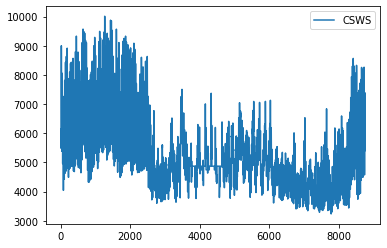

In [11]:
dta[:yr_len].plot()

In [20]:
# load_spp_eia_Jun19_Oct22_nan_removed.index.freq = 'min' # not sure if required

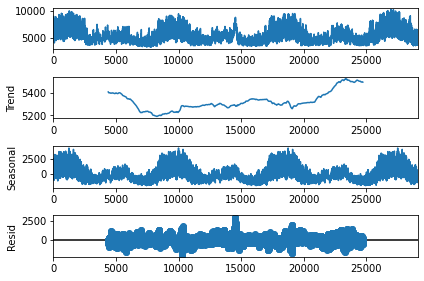

In [23]:
# results = seasonal_decompose(dta, period=1)
results = seasonal_decompose(dta, period=yr_len)
results.plot();

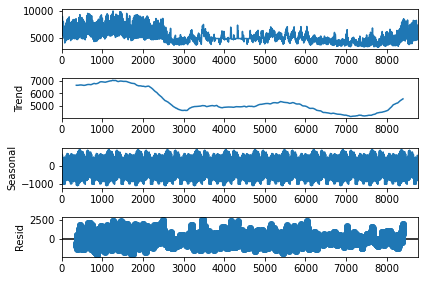

In [24]:
results = seasonal_decompose(dta.iloc[:yr_len], period=month_len)
results.plot();

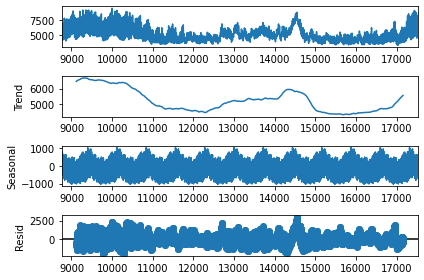

In [26]:
results = seasonal_decompose(dta.iloc[yr_len:2*yr_len], period=month_len)
results.plot();

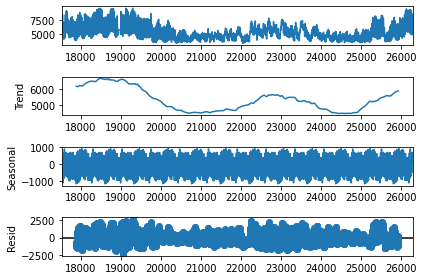

In [27]:
results = seasonal_decompose(dta.iloc[2*yr_len:3*yr_len], period=month_len)
results.plot();

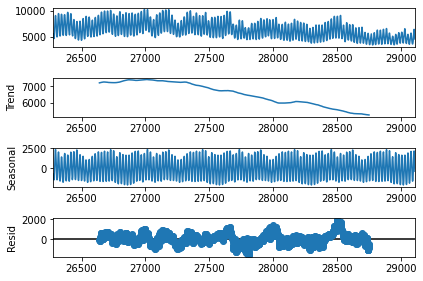

In [28]:
results = seasonal_decompose(dta.iloc[3*yr_len:4*yr_len], period=month_len)
results.plot();

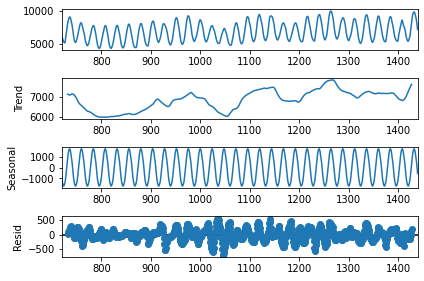

In [31]:
results = seasonal_decompose(dta.iloc[month_len:2*month_len], period=day_len)
results.plot();

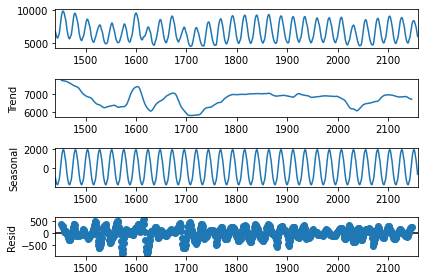

In [32]:
results = seasonal_decompose(dta.iloc[2*month_len:3*month_len], period=day_len)
results.plot();

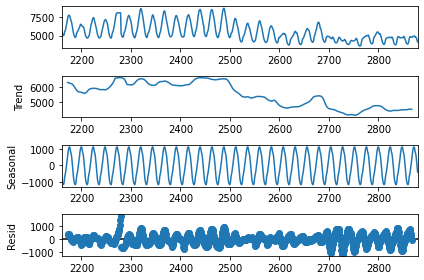

In [33]:
results = seasonal_decompose(dta.iloc[3*month_len:4*month_len], period=day_len)
results.plot();

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


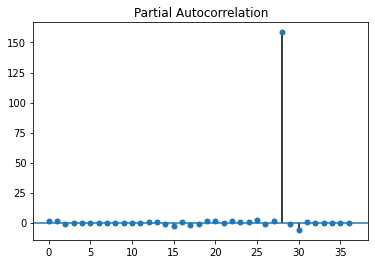

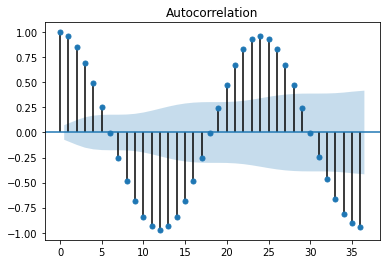

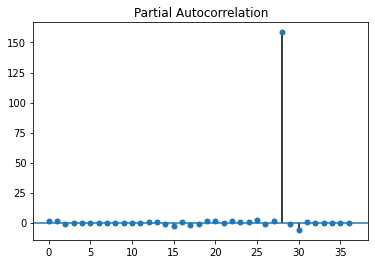

In [34]:
### for 3 yrs of data with period of 1 month
plot_acf(results.seasonal, lags=36)   
plot_pacf(results.seasonal, lags=36)

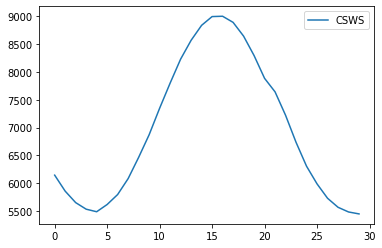

In [37]:
dta.iloc[:30].plot()

In [70]:
train = dta.iloc[:-month_len]   ### approx 
test = dta.iloc[-month_len:]    ### approx 1 month

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [14]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [15]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
# define generator
n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [43]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.41493303 0.37403819 0.3446851  0.32787119 0.32131661 0.33984041
 0.36534625 0.4060986  0.46038757 0.51823881 0.58606441 0.65032773
 0.71174124 0.75990311 0.79823311 0.82060416 0.82145911 0.80578512
 0.77058991 0.72086064 0.66258193 0.62795668 0.56811057 0.49886007
 0.43773155 0.39256198 0.35579937 0.33271587 0.32074665 0.31575948]
Predict this y: 
 [[0.30635509]]


In [44]:
X.shape

(1, 30, 1)

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [46]:
# define model
model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(LSTM(100, activation='tanh', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# model = ks.Sequential([
#     LSTM(100, activation='relu', units=1, input_shape=(n_input, n_features))
# ])
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [50]:
# fit model
model.fit(generator,epochs=5) ### TODO: Run for atleast 15 epochs ~ >30 mins

Epoch 1/5
28362/28362 [==============================] - 145s 5ms/step - loss: 2.9634e-04
Epoch 2/5
28362/28362 [==============================] - 137s 5ms/step - loss: 2.1109e-04
Epoch 3/5
28362/28362 [==============================] - 137s 5ms/step - loss: 1.9702e-04
Epoch 4/5
28362/28362 [==============================] - 133s 5ms/step - loss: 1.8549e-04
Epoch 5/5
28362/28362 [==============================] - 133s 5ms/step - loss: 1.7890e-04


In [51]:
model.save("/content/drive/MyDrive/NYU courses/Sem 3/pTSA/Project/Model/load_spp_eia_Jun19_Oct22")

In [54]:
from keras import models

In [55]:
reconstructed_model = models.load_model("/content/drive/MyDrive/NYU courses/Sem 3/pTSA/Project/Model/load_spp_eia_Jun19_Oct22")

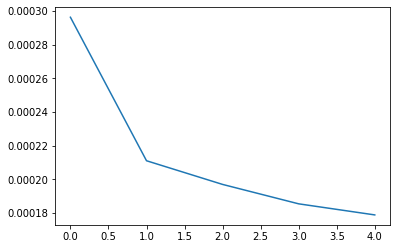

In [56]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [57]:
last_train_batch = scaled_train[-n_input:]

In [58]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [59]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 382ms/step


array([[0.20665348]], dtype=float32)

In [60]:
scaled_test[0]

array([0.200057])

In [71]:
len(test)

720

In [62]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [64]:
test_predictions

[array([0.20665348], dtype=float32),
 array([0.18505901], dtype=float32),
 array([0.17689756], dtype=float32),
 array([0.1762607], dtype=float32),
 array([0.18359637], dtype=float32),
 array([0.20220128], dtype=float32),
 array([0.22994964], dtype=float32),
 array([0.26195544], dtype=float32),
 array([0.2971285], dtype=float32),
 array([0.33635914], dtype=float32),
 array([0.3790701], dtype=float32),
 array([0.42311335], dtype=float32),
 array([0.46544778], dtype=float32),
 array([0.5026956], dtype=float32),
 array([0.5317442], dtype=float32),
 array([0.55030054], dtype=float32),
 array([0.5571488], dtype=float32),
 array([0.55214864], dtype=float32),
 array([0.53617567], dtype=float32),
 array([0.51096445], dtype=float32),
 array([0.47881377], dtype=float32),
 array([0.4423049], dtype=float32),
 array([0.40422127], dtype=float32),
 array([0.36752436], dtype=float32),
 array([0.33510318], dtype=float32),
 array([0.3093896], dtype=float32),
 array([0.29211444], dtype=float32),
 array([0

In [80]:
true_predictions = scaler.inverse_transform(test_predictions).reshape(720)
# true_predictions.reshape(720)
# true_predictions

In [66]:
test

,CSWS
28392,4639.0
28393,4403.0
28394,4238.0
28395,4144.0
28396,4140.0
...,...
29107,5853.0
29108,5535.0
29109,5233.0
29110,4925.0


In [82]:
type(test['CSWS'])

pandas.core.series.Series

In [76]:
test_loc = new_data_len - month_len - 1

In [86]:
# test['Predictions'] = true_predictions
# test.loc[:,'Predictions'] = true_predictions
test.loc[test[test.columns[0]] > 28391, 'Predictions'] = true_predictions

In [ ]:
test.loc[test[test.columns[0]] > test_loc, 'Predictions'] = true_predictions

In [94]:
# test = test.drop(columns='blocks')

In [95]:
test.columns

Index(['CSWS', 'Predictions'], dtype='object')

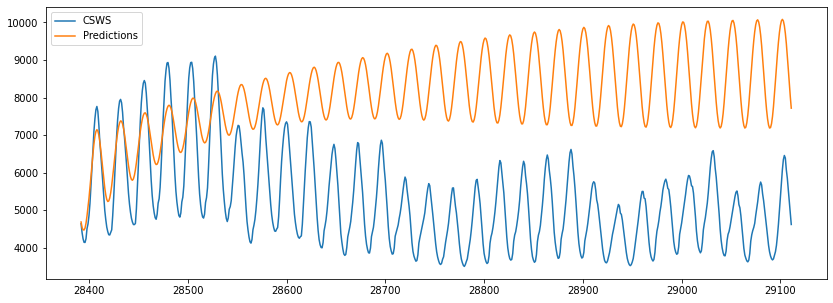

In [96]:
test.plot(figsize=(14,5))

Forecasted with LSTM predicts the variance with similar period as true test data, but doesn't get the mean right.

In [97]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['CSWS'],test['Predictions']))
print(rmse)

3355.1355191446755


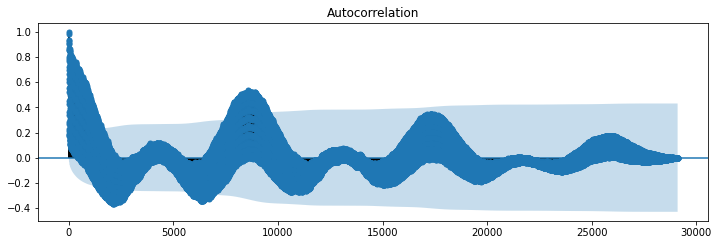

In [25]:
# From Lab 4
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
lags = new_data_len - 1               ### complete length of data
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=lags, ax=ax)
plt.show()

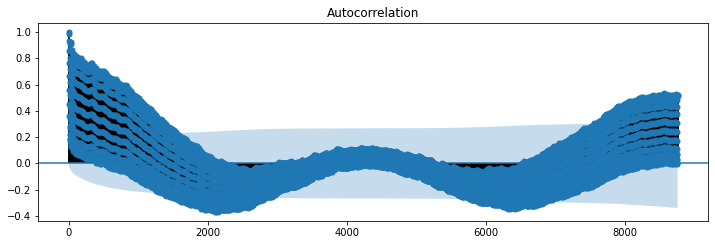

In [28]:
# From Lab 4
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
lags = yr_len                 ### 1 year of data
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=lags, ax=ax1)
plt.show()

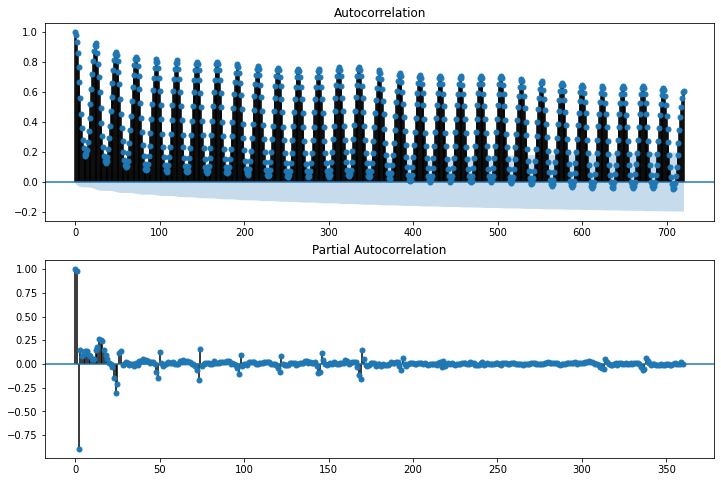

In [32]:
# From Lab 4
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
lags = month_len                 ### 1 month of data
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=lags, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=lags/2, ax=ax2)
plt.show()

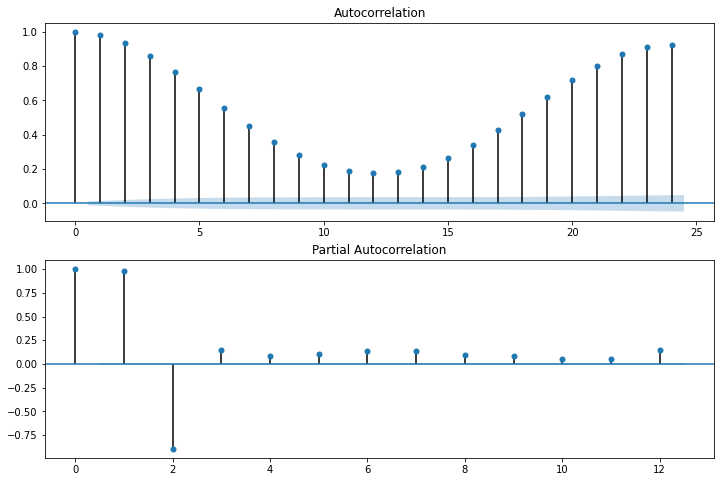

In [30]:
# From Lab 4
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
lags = day_len                 ### 1 day of data
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=lags, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=lags/2, ax=ax2)
plt.show()

ACF does drop around 10, PACF has spike at 1 and negative spike at 2. Maybe choose p = 2?

In [ ]:
#https://www.justintodata.com/arima-models-in-python-time-series-prediction/
# ADF

In [33]:
# https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(dta)
print(f'p-value: {adf_test[1]}')


p-value: 6.697614470366322e-10


ADF test suggests already stationary

Try p = 2

In [35]:
# TODO: chose p appropriately
p = 2

arma_mod = sm.tsa.SARIMAX(dta).fit()
print(arma_mod.params)
# https://www.justintodata.com/arima-models-in-python-time-series-prediction/
# show summary
print(arma_mod.summary())

ar.L1         0.999034
sigma2    60422.935052
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                   CSWS   No. Observations:                29112
Model:               SARIMAX(1, 0, 0)   Log Likelihood             -201560.177
Date:                Mon, 12 Dec 2022   AIC                         403124.353
Time:                        16:34:58   BIC                         403140.911
Sample:                             0   HQIC                        403129.674
                              - 29112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.000   4371.857      0.000       0.999       0.999
sigma2      6.042e+04    301.984    200.086      0.000    5.98e+04    

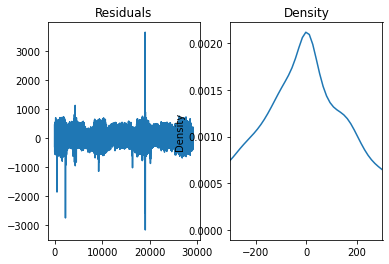

In [36]:
#https://www.justintodata.com/arima-models-in-python-time-series-prediction/
# look at residuals
model_fit = arma_mod
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
ax[1].set_xlim(-300,300)
plt.show()


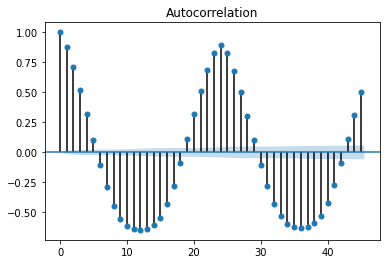

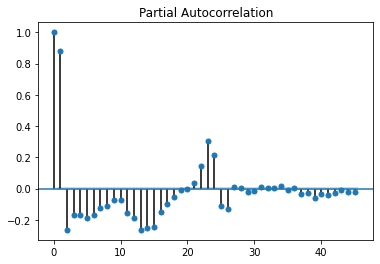

In [102]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)


Looks worse than AR(2).

In [103]:
# TODO: chose p appropriately
p = 27

arma_mod = sm.tsa.SARIMAX(dta, seasonal_order=True).fit()
print(arma_mod.params)
# https://www.justintodata.com/arima-models-in-python-time-series-prediction/
# show summary
print(arma_mod.summary())

ar.L1         0.999034
sigma2    60422.935052
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                   CSWS   No. Observations:                29112
Model:               SARIMAX(1, 0, 0)   Log Likelihood             -201560.177
Date:                Mon, 12 Dec 2022   AIC                         403124.353
Time:                        14:55:37   BIC                         403140.911
Sample:                             0   HQIC                        403129.674
                              - 29112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.000   4371.857      0.000       0.999       0.999
sigma2      6.042e+04    301.984    200.086      0.000    5.98e+04    

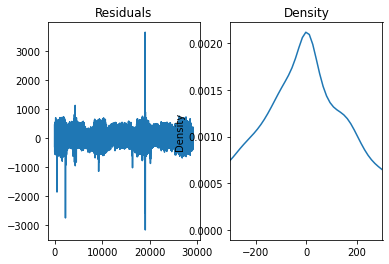

In [104]:
#https://www.justintodata.com/arima-models-in-python-time-series-prediction/
# look at residuals
model_fit = arma_mod
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
ax[1].set_xlim(-300,300)
plt.show()


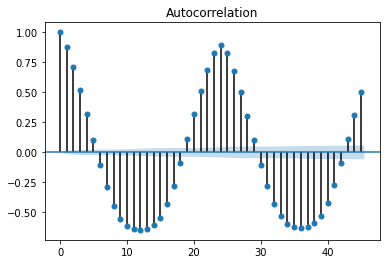

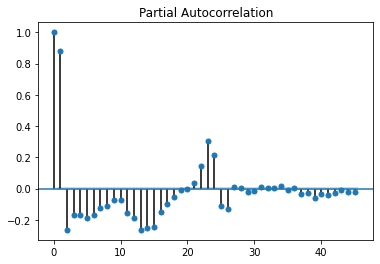

In [105]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)


Gives similar ACF and PACF graphs. Cause of seasonality?

In [38]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.2 MB/s 
     |████████████████████████████████| 9.9 MB 39.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [39]:
import pmdarima as pm

### SARIMA
Take a look SARIMA

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

In [40]:
auto_sarima = pm.auto_arima(dta, stepwise=False, seasonal=True)
auto_sarima

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [41]:
auto_sarima = pm.auto_arima(dta["CSWS"], stepwise=False, seasonal=True)
auto_sarima

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [42]:
auto_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                29112
Model:               SARIMAX(2, 1, 3)   Log Likelihood             -175250.332
Date:                Mon, 12 Dec 2022   AIC                         350514.664
Time:                        16:54:13   BIC                         350572.616
Sample:                             0   HQIC                        350533.285
                              - 29112                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0055      0.029     -0.189      0.850      -0.062       0.051
ar.L1          1.8840      0.002    797.528      0.000       1.879       1.889
ar.L2         -0.9550      0.002   -438.217      0.000      -0.959      -0.951
ma.L1         -1.0898      0.003   -385.751      0.000      -1.095      -1.084
ma.L2         -0.0375      0.003    -10.866      0.000      -0.044      -0.031
ma.L3          0.1738      0.004     45.977      0.000       0.166       0.181
sigma2      9916.2393     18.133    546.856      0.000    9880.699    9951.780
===================================================================================
Ljung-Box (L1) (Q):                  12.36   Jarque-Bera (JB):          38815486.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                       181.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<ipython-input-43-a979b84329be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dta['forecast_auto'] = [None]*len(train) + list(forecast_test_auto)


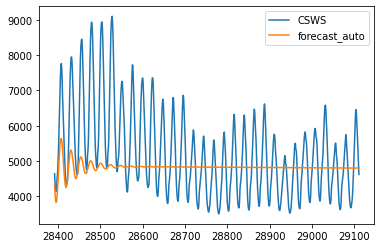

In [43]:
forecast_test_auto = auto_sarima.predict(n_periods=len(test))
dta['forecast_auto'] = [None]*len(train) + list(forecast_test_auto)

#df.plot()
dta[['CSWS','forecast_auto']].iloc[-month_len:].plot()

Forecasted with auto_sarima predicts the mean to some extent, but doesn't get the variance of the data.

Try to combine RNN predictions with that of auto_sarima by adding RNN predictions to auto_sarima predictions and subtracting RNN-prediction's mean.

In [46]:
from keras import models

In [47]:
reconstructed_model = models.load_model("/content/drive/MyDrive/NYU courses/Sem 3/pTSA/Project/Model/load_spp_eia_Jun19_Oct22")

In [48]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = reconstructed_model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [64]:
true_predictions = scaler.inverse_transform(test_predictions).reshape(720)

In [65]:
true_predictions -= true_predictions.mean()

In [60]:
new_predictions = dta['forecast_auto'].iloc[-month_len:].to_numpy(copy=True) + true_predictions

In [104]:
test.loc[test['index'] > test_loc, 'New Predictions'] = new_predictions

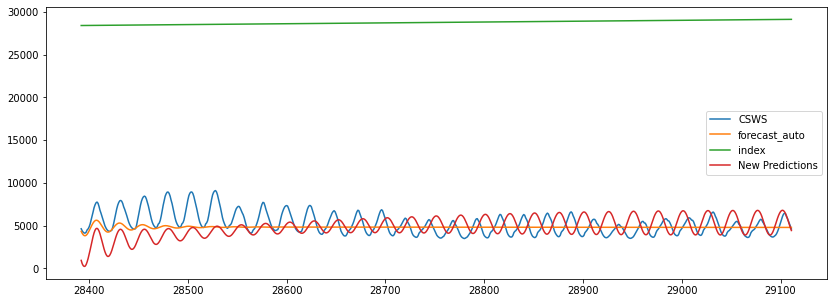

In [105]:
test.plot(figsize=(14,5))

This results in close predictions with the actual test data.